In [1]:
import sys  
sys.path.insert(1, '/Users/simon/Documents/II/Dissertation/')
%load_ext autoreload
%autoreload 2
from src.misc import load_processed_dataset, evaluate
import torch
import numpy as np
import pandas as pd
import yaml
import matplotlib.pyplot as plt

https://medium.com/@lucasastorian/understanding-financial-feature-importance-7eeb49c2df0b

# Feature Selection

In [2]:
df = load_processed_dataset("aapl")
X = df.drop([x for x in df.columns if "Forecast" in x], axis=1) 
y = df['Close Forecast']

## Filter Methods

Correlation Coefficient

We won't use this in aggregate score because only detects linear relationships.

<Axes: >

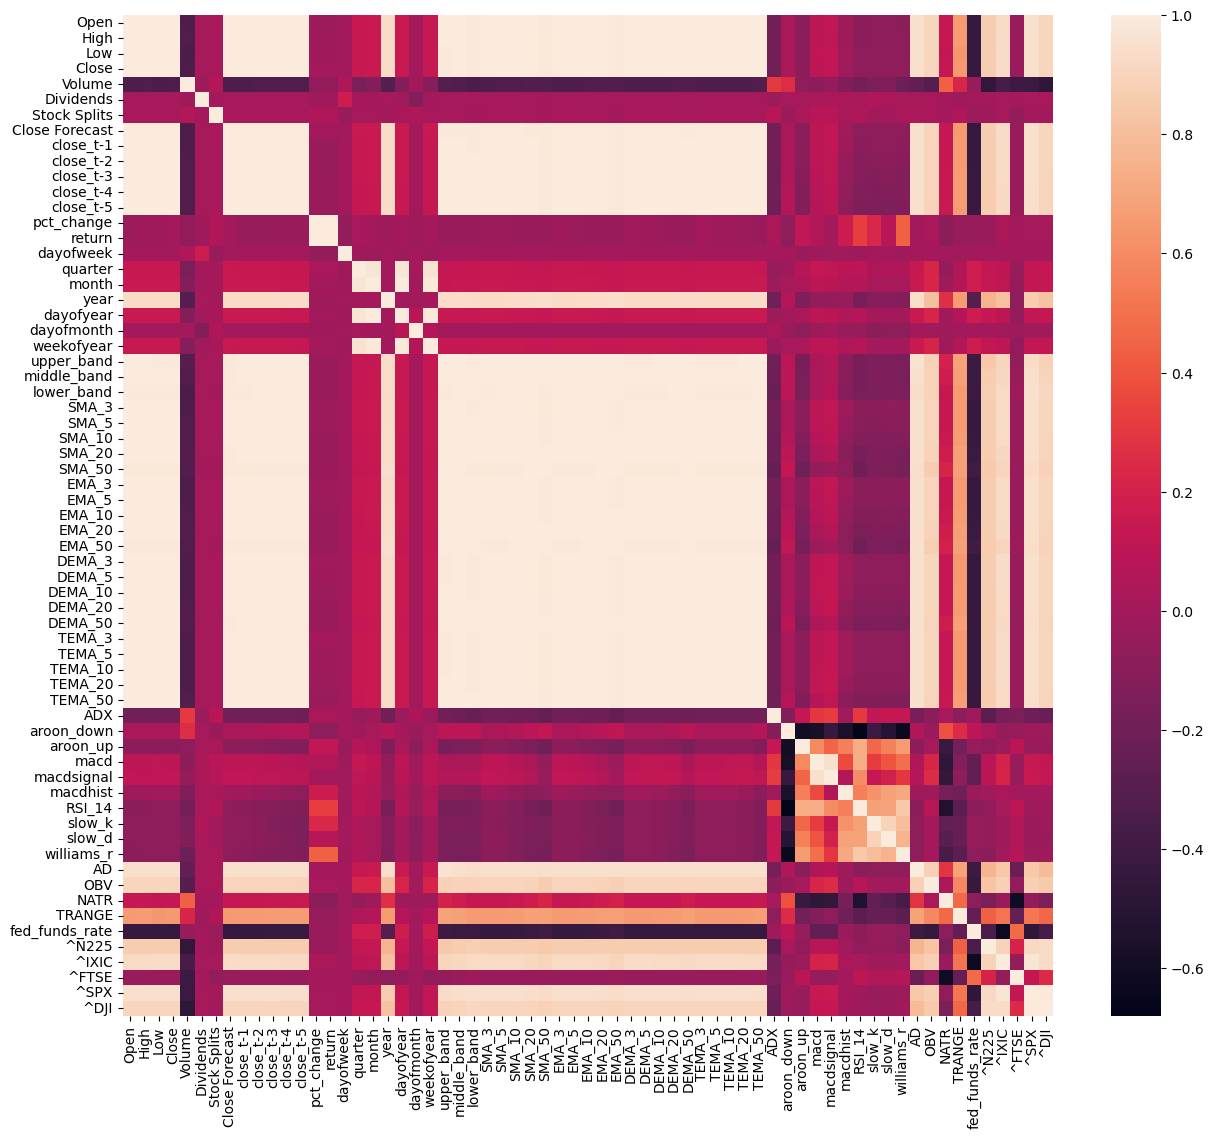

In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df.corr()

plt.figure(figsize=(15, 13))  # Increase figure size
sns.heatmap(correlation_matrix, fmt=".2g")

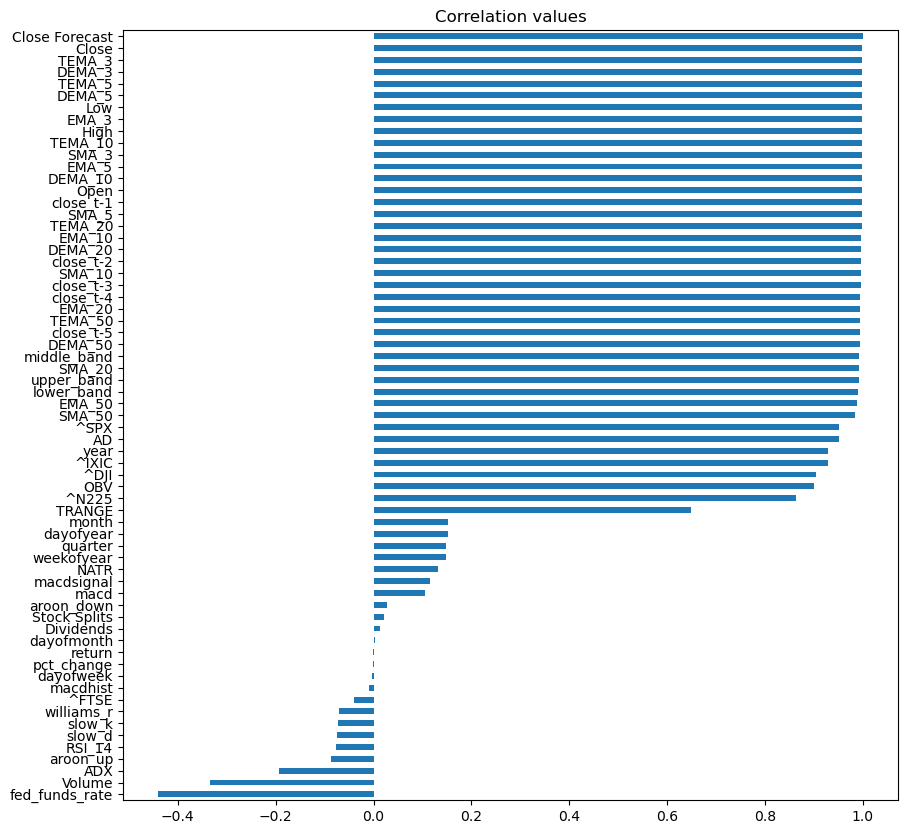

In [71]:
corr_values = correlation_matrix['Close Forecast'].sort_values(ascending=True)
corr_values.plot.barh(figsize=(10, 10))
plt.title('Correlation values')
plt.show()

Mutual Information

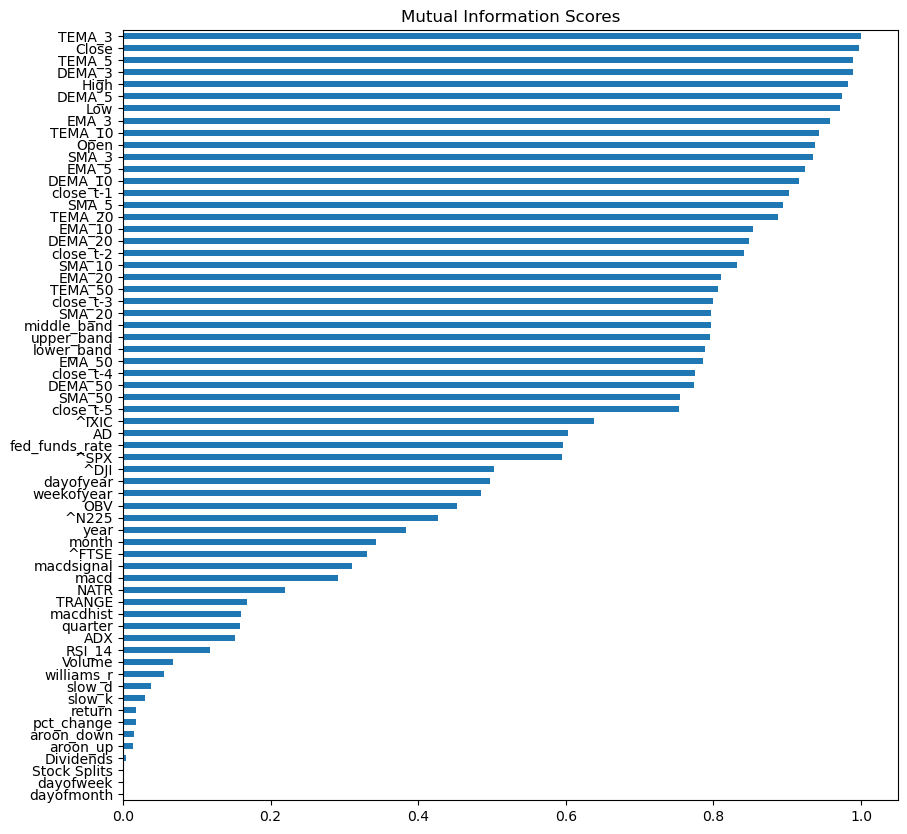

In [58]:
from sklearn.feature_selection import mutual_info_regression
import pandas as pd
import numpy as np

mi_scores = mutual_info_regression(X, y, random_state=42)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=True)  # Sorting the scores
mi_scores = (mi_scores - min(mi_scores)) / (max(mi_scores) - min(mi_scores)) # Normalise
mi_scores.plot.barh(figsize=(10, 10))
plt.title('Mutual Information Scores')
plt.show()

# Model Agnostic Methods

Single Feature Performance

Abandoned due to time cost

In [ ]:
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")

with open("../configs/lstm_tune.yaml", "r") as file:
    config = yaml.safe_load(file)
assert config["data"]["init_args"]["feature_set"] == list(X.columns)
feature_set = config["data"]["init_args"]["feature_set"]

feature_scores = []
for f in tqdm(feature_set):
    cur_config = config.copy()
    cur_config["data"]["init_args"]["feature_set"] = [f]
    cli = BaseCLI(
        run=False,
        parser_kwargs={"default_config_files": ["../configs/cli_defaults.yaml"]},
        args=config,
    )
    cli.trainer.fit(model=cli.model, datamodule=cli.datamodule)
    val_metrics = cli.trainer.validate(model=cli.model, datamodule=cli.datamodule, ckpt_path="best")[0]
    test_metrics = cli.trainer.test(model=cli.model, datamodule=cli.datamodule, ckpt_path="best")[0]

    feature_scores.append({
        "feature": f,
        "val_rmse": val_metrics["val_rmse"],
        "test_rmse": test_metrics["test_rmse"]
    })
    

Permutation Feature Importance

/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/lightning/pytorch/cli.py:520: LightningCLI's args parameter is intended to run from within Python like if it were from the command line. To prevent mistakes it is not recommended to provide both args and command line arguments, got: sys.argv[1:]=['--f=/Users/simon/Library/Jupyter/runtime/kernel-v2-6677mlgr84Kb8V46.json'], args={'experiment_name': 'lstm_brk-b_all', 'model': {'class_path': 'src.models.LSTM_Lightning.model.StockPricePredictor', 'init_args': {'sequence_len': 30, 'hidden_dim': 64, 'num_layers': 1, 'lr': 0.001, 'dropout': 0}}, 'data': {'class_path': 'src.models.LSTM_Lightning.data.StockDataModule', 'init_args': {'stock': 'aapl', 'feature_set': ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'close_t-1', 'close_t-2', 'close_t-3', 'close_t-4', 'close_t-5', 'pct_change', 'return', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'upper_band', 'middle_band', 'low

R^2: -1.0060768198986856
MSE: 143.60673476112956
RMSE: 11.983602745465554
MAE: 11.002668975501932
MAPE: 5.960126320013128
R^2: -2.089977608778503
MSE: 226.41339320503675
RMSE: 15.047039350152467
MAE: 13.649264231035787
MAPE: 7.385379290116556


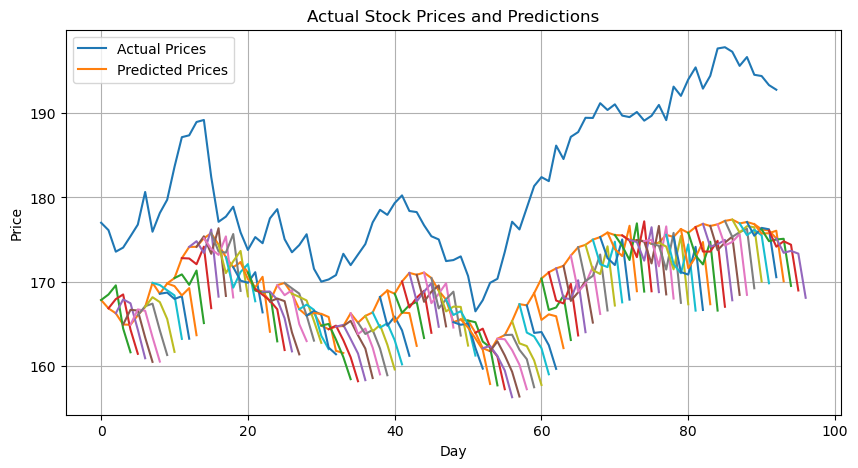

In [60]:
from tqdm import tqdm
import warnings
import logging
from src.models.LSTM_Lightning.data import StockDataModule
from src.models.LSTM_Lightning.tune import BaseCLI
warnings.filterwarnings("ignore", ".*does not have many workers.*")
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.WARNING) # Disables printings about GPU/TPU

with open("../configs/lstm_tune.yaml", "r") as file:
    config = yaml.safe_load(file)
config_data = config["data"]["init_args"]
feature_set = config_data["feature_set"]
assert feature_set == list(X.columns)

cli = BaseCLI(
        run=False,
        parser_kwargs={"default_config_files": ["../configs/cli_defaults.yaml"]},
        args=config,
    )
cli.trainer.fit(model=cli.model, datamodule=cli.datamodule)
base_val_metrics = cli.trainer.validate(model=cli.model, datamodule=cli.datamodule, ckpt_path="best", verbose=False)[0]
base_test_metrics = cli.trainer.test(model=cli.model, datamodule=cli.datamodule, ckpt_path="best", verbose=False)[0]

predictions, actuals = cli.model.predictions, cli.model.actuals
one_day_actuals = actuals[:,0]
one_day_predictions = predictions[:,0]
evaluate(one_day_predictions, one_day_actuals, verbose=True)
evaluate(predictions, actuals, verbose=True)
plt.figure(figsize=(10, 5))
plt.plot(one_day_actuals, label='Actual Prices')
plt.plot(one_day_predictions, label='Predicted Prices')
for index, preds in enumerate(predictions):
    plt.plot(np.arange(index, index+cli.datamodule.horizon), preds)
plt.title('Actual Stock Prices and Predictions')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [59]:
from src.models.LSTM_Lightning.data import StockDataModule

pfi_scores = [{
    "feature": "(baseline)",
    "val_rmse": base_val_metrics["val_rmse"],
    "test_rmse": base_test_metrics["test_rmse"],
    "val_importance": 0,
    "test_importance": 0,
}]

for f in (pbar := tqdm(feature_set)):
    pbar.set_description(f"Permuting feature {f}")
    permuted_dm = StockDataModule(
        stock=config_data["stock"],
        feature_set=config_data["feature_set"],
        sequence_len=config_data["sequence_len"],
        batch_size=config_data["batch_size"],
        dataset_len=config_data["dataset_len"],
        horizon=config_data["horizon"],
        permute_column=f
    )

    val_metrics = cli.trainer.validate(model=cli.model, datamodule=permuted_dm, ckpt_path="best", verbose=False)[0]
    test_metrics = cli.trainer.test(model=cli.model, datamodule=permuted_dm, ckpt_path="best", verbose=False)[0]
    pfi_scores.append({
        "feature": f,
        "val_rmse": val_metrics["val_rmse"],
        "test_rmse": test_metrics["test_rmse"],
        "val_importance": val_metrics["val_rmse"] -  base_val_metrics["val_rmse"],
        "test_importance": test_metrics["test_rmse"] -  base_test_metrics["test_rmse"],
    })

pfi_scores = pd.DataFrame(pfi_scores)

Permuting feature ^DJI: 100%|██████████| 64/64 [00:18<00:00,  3.44it/s]          


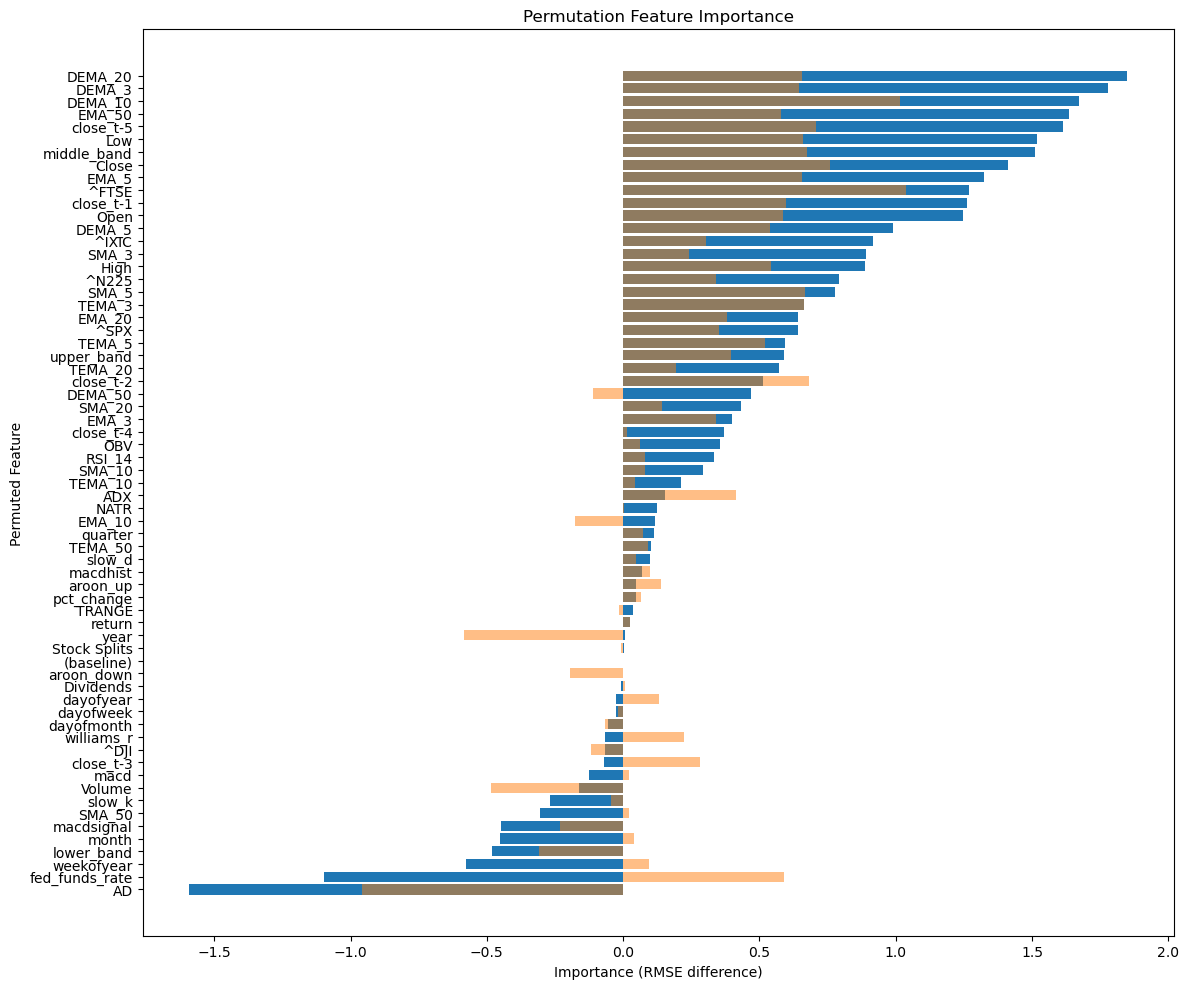

In [50]:
pfi_scores = pfi_scores.sort_values(by="test_importance", ascending=True)
plt.figure(figsize=(12, 10))
plt.barh(pfi_scores['feature'], pfi_scores['test_importance'])
plt.barh(pfi_scores['feature'], pfi_scores['val_importance'], alpha=0.5)
plt.xlabel('Importance (RMSE difference)')
plt.ylabel('Permuted Feature')
plt.title('Permutation Feature Importance')
plt.tight_layout()
plt.show()

Combining MI and PFI

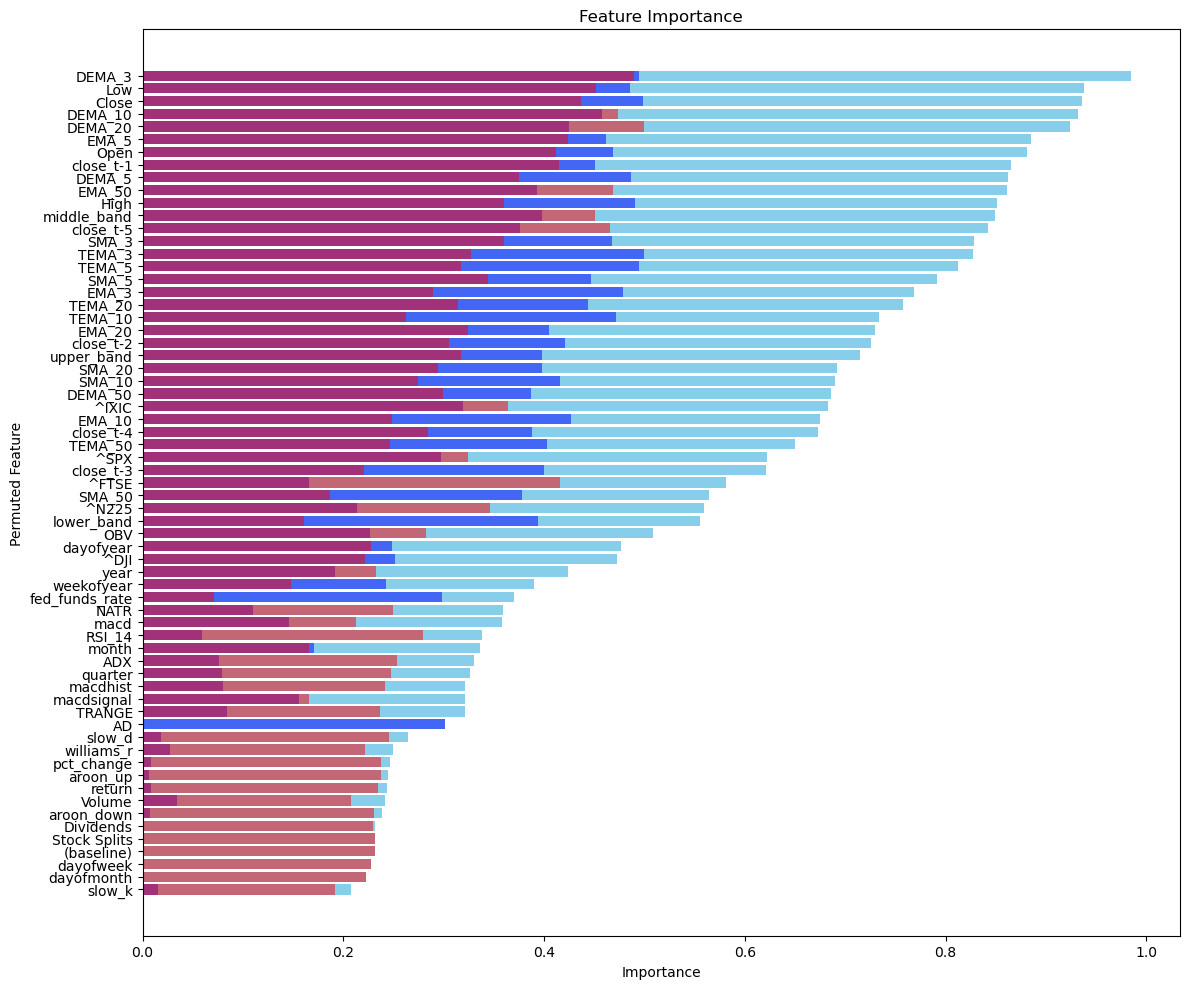

In [109]:
pfi_scores = pd.Series(data = pfi_scores["test_importance"].values, index=pfi_scores["feature"])
pi_scores_norm = (pfi_scores - min(pfi_scores)) / (max(pfi_scores) - min(pfi_scores))
comb_scores = (pi_scores_norm/2).add(mi_scores/2, fill_value=0)
comb_scores = comb_scores.sort_values()
# Plotting
plt.figure(figsize=(12, 10))
plt.barh(comb_scores.index, comb_scores.values, color="skyblue")
plt.barh(mi_scores.index, mi_scores.values/2, alpha=0.5, color="blue")
plt.barh(pi_scores_norm.index, pi_scores_norm.values/2, alpha=0.5, color="red")
plt.xlabel('Importance')
plt.ylabel('Permuted Feature')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

Evaluating all feature sets

In [95]:
feature_sets = {
    "ohlcv": ["Open", "High", "Low", "Close", "Volume"],
    "all": feature_set,
}

ks = [10, 30, 50]
for k in ks:
    feature_sets[f"top_{k}"] = comb_scores.nlargest(k).index.tolist()
    

In [97]:
with open("../configs/lstm_tune.yaml", "r") as file:
    config = yaml.safe_load(file)

fset_scores = []
for f_set_name, features in (pbar := tqdm(feature_sets.items())):
    pbar.set_description(f"Fitting model to feature set: {f_set_name}")
    cur_config = config.copy()
    cur_config["data"]["init_args"]["feature_set"] = features
    cli = BaseCLI(
            run=False,
            parser_kwargs={"default_config_files": ["../configs/cli_defaults.yaml"]},
            args=config,
        )
    cli.trainer.fit(model=cli.model, datamodule=cli.datamodule)
    val_metrics = cli.trainer.validate(model=cli.model, datamodule=cli.datamodule, ckpt_path="best", verbose=False)[0]
    test_metrics = cli.trainer.test(model=cli.model, datamodule=cli.datamodule, ckpt_path="best", verbose=False)[0]

    fset_scores.append({
        "feature_set": f_set_name,
        "val_rmse": val_metrics["val_rmse"],
        "test_rmse": test_metrics["test_rmse"]
    })

fset_scores = pd.DataFrame(fset_scores)

Fitting model to feature set: ohlcv:   0%|          | 0/5 [00:00<?, ?it/s]/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/lightning/pytorch/cli.py:520: LightningCLI's args parameter is intended to run from within Python like if it were from the command line. To prevent mistakes it is not recommended to provide both args and command line arguments, got: sys.argv[1:]=['--f=/Users/simon/Library/Jupyter/runtime/kernel-v2-6677mlgr84Kb8V46.json'], args={'experiment_name': 'lstm_brk-b_all', 'model': {'class_path': 'src.models.LSTM_Lightning.model.StockPricePredictor', 'init_args': {'sequence_len': 30, 'hidden_dim': 64, 'num_layers': 1, 'lr': 0.001, 'dropout': 0}}, 'data': {'class_path': 'src.models.LSTM_Lightning.data.StockDataModule', 'init_args': {'stock': 'aapl', 'feature_set': ['Open', 'High', 'Low', 'Close', 'Volume'], 'sequence_len': 30, 'batch_size': 16, 'permute_column': None, 'dataset_len': 5, 'horizon': 5}}}.
Seed set to 42
Fitting model to feature set: all:  20%|██    

,feature_set,val_rmse,test_rmse
0,ohlcv,4.058506,5.781800
1,all,7.031413,15.047040
2,top_10,3.497426,4.808778
3,top_30,4.608996,7.067623
4,top_50,7.533606,15.640504


In [106]:
selected_fset = fset_scores.loc[fset_scores['test_rmse'].idxmin()]['feature_set']

In [108]:
feature_sets[selected_fset]

['DEMA_3',
 'Low',
 'Close',
 'DEMA_10',
 'DEMA_20',
 'EMA_5',
 'Open',
 'close_t-1',
 'DEMA_5',
 'EMA_50']

# Rejected Approaches

## Wrapper Methods

Recursive Feature Elimination

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

# Select a model for feature ranking
model = RandomForestRegressor(n_estimators=100)

# RFE
selector = RFE(estimator=model, n_features_to_select=20, step=1)
selector = selector.fit(X, y)

# Selected Features
selected_features = selector.support_
selected_feature_names = X.columns[selected_features]
print("Selected features:", selected_feature_names.tolist())


KeyboardInterrupt: 

Sequential Feature Selection (SFS)

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

# Linear model for SFS
lr = LinearRegression()

# Forward SFS (set forward=True for forward selection)
sfs = SequentialFeatureSelector(lr, n_features_to_select=10, direction='forward')
sfs.fit(X, y)

# Selected Features
selected_features = sfs.get_support()
selected_feature_names = X.columns[selected_features]
print("Selected features:", selected_feature_names.tolist())

Selected features: ['Close', 'close_t-2', 'close_t-3', 'dayofweek', 'year', 'dayofmonth', 'aroon_down', 'williams_r', 'TRANGE', 'log_fed_funds_rate']


In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

# Linear model for SFS
lr = LinearRegression()

# Forward SFS (set forward=True for forward selection)
sfs = SequentialFeatureSelector(lr, n_features_to_select=3, direction='backward')
sfs.fit(X, y)

# Selected Features
selected_features = sfs.get_support()
selected_feature_names = X.columns[selected_features]
print("Selected features:", selected_feature_names.tolist())

Selected features: ['Close', 'log_open', 'fed_funds_rate']


## Embedded Methods

LASSO (L1 Regularization)

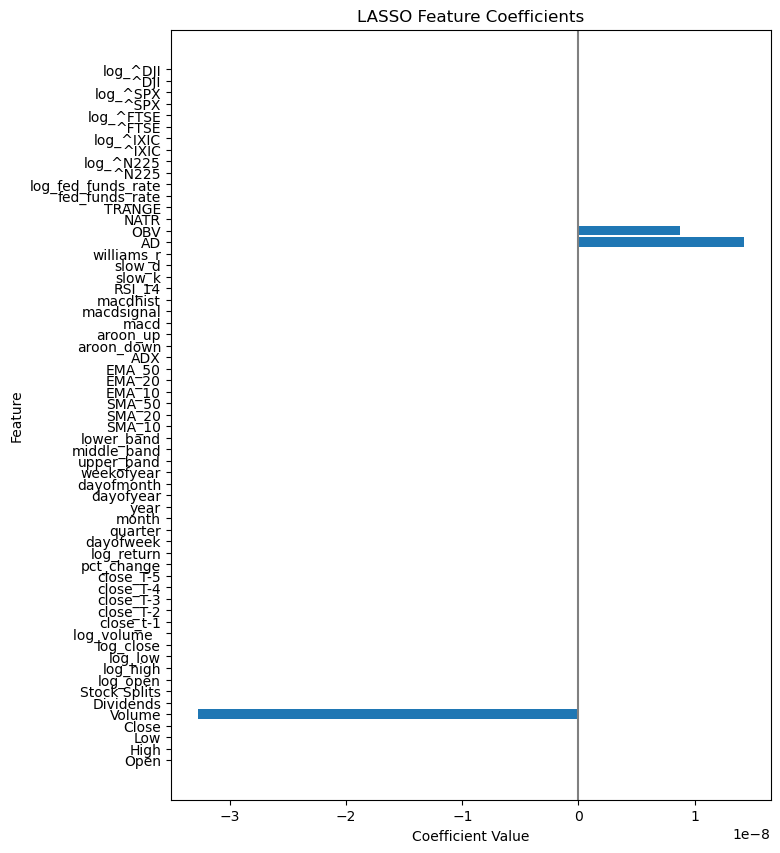

In [ ]:
from sklearn.linear_model import LassoCV
import numpy as np

# LASSO with cross-validation to find the best alpha (regularization strength)
lasso = LassoCV(random_state=42).fit(X, y)

# Plot
plt.figure(figsize=(10, 10))
plt.barh(range(X.shape[1]), lasso.coef_, align='center')
plt.yticks(np.arange(X.shape[1]), X.columns)
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.title("LASSO Feature Coefficients")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)
plt.show()


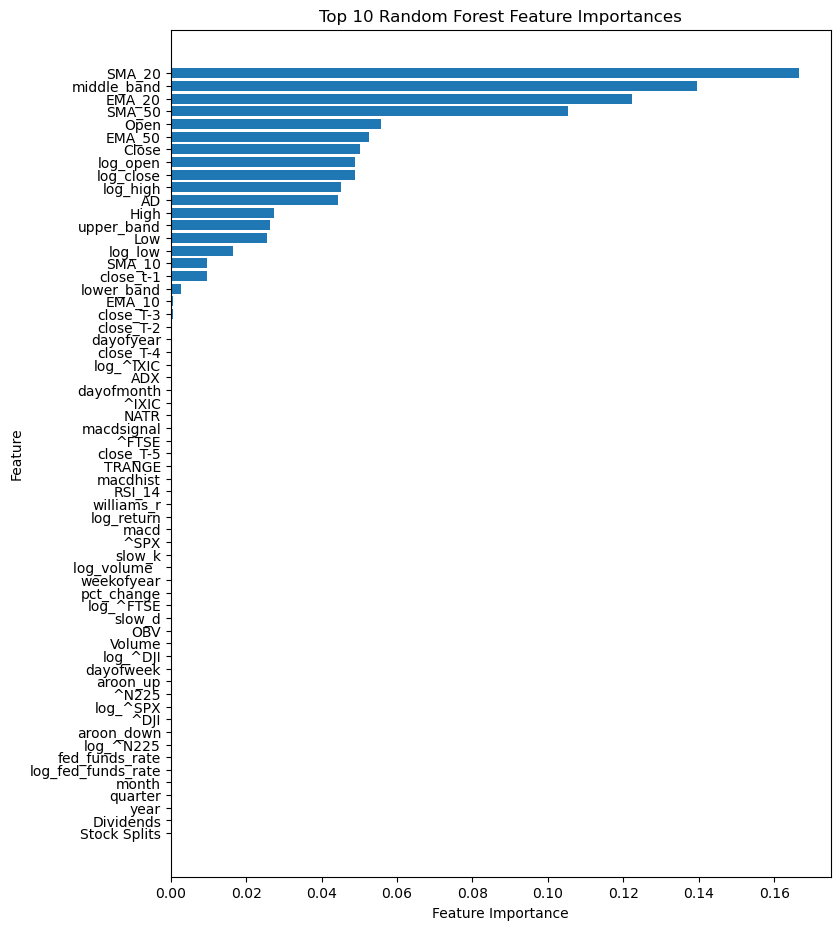

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

# Random Forest for feature importance
rf = RandomForestRegressor(n_estimators=100, random_state=42).fit(X, y)

# Feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot top N features
N = len(X.columns)  # Number of top features to display
plt.figure(figsize=(11, 11))
plt.barh(range(N), importances[indices[:N]], align='center')
plt.yticks(np.arange(N), [X.columns[i] for i in indices[:N]])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 10 Random Forest Feature Importances")
plt.subplots_adjust(left=0.3)
plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
plt.show()

In [ ]:
# Plot top N features
plt.figure(figsize=(10, 10))
plt.barh(range(N), importances[indices[:N]], align='center')
plt.yticks(np.arange(N), [X.columns[i] for i in indices[:N]])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 10 Random Forest Feature Importances")
plt.subplots_adjust(left=0.3)
plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
plt.xlim(0,0.0025)
plt.show()

NameError: name 'N' is not defined

<Figure size 1000x1000 with 0 Axes>

## Permutation Feature Importance (Column-Drop Variant)

In [ ]:
import warnings

warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")
warnings.filterwarnings("ignore", ".*Checkpoint directory.*exists and is not empty.")
warnings.filterwarnings("ignore", ".*The number of training batches (.*) is smaller")

torch.manual_seed(42)

perm_importances = []
for feature_to_drop in features:
    new_feature_set = [f for f in features if f != feature_to_drop]
    model = StockPricePredictor(new_feature_set, sequence_len, len(new_feature_set), hidden_dim, num_layers, output_dim, lr)
    data_module = StockDataModule("aapl", new_feature_set, sequence_len, batch_size)
    logger = TensorBoardLogger("tb_logs", name=f"lstm_pi_drop_{feature_to_drop}", default_hp_metric=False)
    checkpoint_callback = ModelCheckpoint(dirpath="models/", save_top_k=2, monitor="hp/rmse")
    trainer = Trainer(max_epochs=num_epochs, callbacks=[checkpoint_callback], logger=logger, enable_progress_bar=False, enable_model_summary=False)
    trainer.fit(model, datamodule=data_module)

    val_metrics = trainer.validate(datamodule=data_module, ckpt_path="best", verbose=False)
    perm_importances.append({
        "dropped_feature": feature_to_drop,
        "rmse": val_metrics[0]["hp/rmse"],
        "importance": val_metrics[0]["hp/rmse"] - base_rmse
    })
    print(f"{feature_to_drop}: {val_metrics[0]['hp/rmse'] - base_rmse}")
perm_importances


Open: -0.6198768615722656
High: -2.7218875885009766
Low: -1.363525390625
Close: -0.8266353607177734
Volume: -0.19973468780517578
Dividends: -0.4063596725463867
Stock Splits: 0.33273887634277344
close_t-1: -2.1524505615234375
close_t-2: -0.0051708221435546875
close_t-3: 2.136857032775879
close_t-4: -1.8818588256835938
close_t-5: -1.1553573608398438
pct_change: 1.5531063079833984
return: -1.0216188430786133
dayofweek: -0.11219978332519531
quarter: -0.026906967163085938
month: -2.866300582885742
year: -0.9714679718017578
dayofyear: -0.438201904296875
dayofmonth: -0.17662715911865234
weekofyear: -2.835394859313965
upper_band: -1.475031852722168
middle_band: -1.5739574432373047
lower_band: -1.3671636581420898
SMA_3: -1.2612180709838867
SMA_5: -0.5437421798706055
SMA_10: -1.5910024642944336
SMA_20: 1.5716371536254883
SMA_50: 0.30545711517333984
EMA_3: -2.9904356002807617
EMA_5: -0.11857223510742188
EMA_10: 0.4315004348754883
EMA_20: -1.8994951248168945
EMA_50: 1.8188304901123047
DEMA_3: -0.0

[{'dropped_feature': 'Open',
  'rmse': 13.407116889953613,
  'importance': -0.6198768615722656},
 {'dropped_feature': 'High',
  'rmse': 11.305106163024902,
  'importance': -2.7218875885009766},
 {'dropped_feature': 'Low',
  'rmse': 12.663468360900879,
  'importance': -1.363525390625},
 {'dropped_feature': 'Close',
  'rmse': 13.200358390808105,
  'importance': -0.8266353607177734},
 {'dropped_feature': 'Volume',
  'rmse': 13.827259063720703,
  'importance': -0.19973468780517578},
 {'dropped_feature': 'Dividends',
  'rmse': 13.620634078979492,
  'importance': -0.4063596725463867},
 {'dropped_feature': 'Stock Splits',
  'rmse': 14.359732627868652,
  'importance': 0.33273887634277344},
 {'dropped_feature': 'close_t-1',
  'rmse': 11.874543190002441,
  'importance': -2.1524505615234375},
 {'dropped_feature': 'close_t-2',
  'rmse': 14.021822929382324,
  'importance': -0.0051708221435546875},
 {'dropped_feature': 'close_t-3',
  'rmse': 16.163850784301758,
  'importance': 2.136857032775879},
 {

In [ ]:
df = pd.DataFrame(perm_importances).sort_values(by="importance", ascending=False).reset_index()
# Plotting
plt.figure(figsize=(12, 10))
plt.barh(df['dropped_feature'], df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Dropped Feature')
plt.title('Permutation Feature Importance (Column-Drop Variant)')
plt.tight_layout()
plt.show()

NameError: name 'perm_importances' is not defined